In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import argparse
import torch
import spacy
import pickle
import json
from transformers import BertTokenizerFast

import matplotlib.pyplot as plt
from tqdm.notebook import tqdm, trange

from diffmask.models.sentiment_classification_sst import (
    BertSentimentClassificationSST,
    RecurrentSentimentClassificationSST,
)

from diffmask.attributions.integrated_gradient import (
    sst_bert_integrated_gradient,
    sst_gru_integrated_gradient,
)
from diffmask.attributions.schulz import (
    bert_hidden_states_statistics,
    sst_gru_hidden_states_statistics,
    sst_bert_schulz_explainer,
    sst_gru_schulz_explainer,
)
from diffmask.attributions.guan import (
    sst_bert_guan_explainer,
    sst_gru_guan_explainer,
)

from diffmask.utils.getter_setter import gru_getter, gru_setter
from diffmask.utils.plot import plot_sst_attributions

In [3]:
if __name__ == "__main__":
    parser = argparse.ArgumentParser()
    parser.add_argument("--gpu", type=str, default="0")
    parser.add_argument("--model", type=str, default="bert-base-uncased")
    parser.add_argument("--train_filename", type=str, default="./datasets/sst/train.txt")
    parser.add_argument("--val_filename", type=str, default="./datasets/sst/dev.txt")
    parser.add_argument("--batch_size", type=int, default=64)
    parser.add_argument("--seed", type=int, default=0)
    parser.add_argument("--architecture", type=str, default="bert", choices=["gru", "bert"])
    parser.add_argument(
        "--model_path",
        type=str,
        default="models/sst.ckpt",
    )
    parser.add_argument("--eps_valid", type=int, default=0.05)
    
    hparams, _ = parser.parse_known_args()
    
    torch.manual_seed(hparams.seed)
    
    os.environ["CUDA_VISIBLE_DEVICES"] = hparams.gpu

# Loading model

In [4]:
device = "cuda:0"

if hparams.architecture == "bert":
    model = BertSentimentClassificationSST.load_from_checkpoint(hparams.model_path).to(device)
    integrated_gradient = sst_bert_integrated_gradient
    hidden_states_statistics = bert_hidden_states_statistics
    schulz_explainer = sst_bert_schulz_explainer
    guan_explainer = sst_bert_guan_explainer
    
elif hparams.architecture == "gru":
    model = RecurrentSentimentClassificationSST.load_from_checkpoint(hparams.model_path).to(device)
    integrated_gradient = sst_gru_integrated_gradient
    hidden_states_statistics = sst_gru_hidden_states_statistics
    schulz_explainer = sst_gru_schulz_explainer
    guan_explainer = sst_gru_guan_explainer
    
model.freeze()
model.prepare_data()

# Create example

In [5]:
source = "A fast , funny , highly enjoyable movie ."

inputs_dict = {
    k: v.to(device)
    for k, v in model.tokenizer.encode_plus(
        source,
        max_length=84,
        pad_to_max_length=True,
        return_tensors="pt",
    ).items()
}
inputs_dict["mask"] = inputs_dict["attention_mask"]
inputs_dict["labels"] = torch.tensor([4]).to(device) # very positive
del inputs_dict["attention_mask"]
del inputs_dict["token_type_ids"]

source = model.tokenizer.tokenize(source)
tokens = ["[CLS]"]  + source + ["[SEP]"]

# Sundararajan et al. (2017) - Integrated Gradient

In [6]:
attributions_ig = torch.cat([integrated_gradient(
    model,
    inputs_dict,
    hidden_state_idx=i,
    steps=50,
) for i in range(14)], 0).sum(-1).abs().T

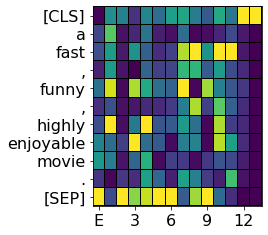

In [7]:
plot_sst_attributions(
    attributions_ig[:inputs_dict["mask"].sum(-1).item()].cpu(),
    tokens,
)

# Schulz et al. (2020)

In [8]:
all_q_z_loc, all_q_z_scale = hidden_states_statistics(model, input_only=False)

In [9]:
attributions_schulz = torch.cat([schulz_explainer(
    model,
    inputs_dict,
    all_q_z_loc,
    all_q_z_scale,
    hidden_state_idx=i,
    steps=50,
    lr=1e-1,
    la=10,
) for i in range(14)], 0).T

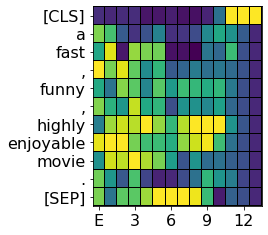

In [10]:
plot_sst_attributions(
    attributions_schulz[:inputs_dict["mask"].sum(-1).item()].cpu(),
    tokens,
)

# Guan et al. (2019)

In [11]:
attributions_guan = - torch.cat([guan_explainer(
    model,
    inputs_dict,
    hidden_state_idx=i,
    steps=50,
    lr=1e-1,
    la=1e-1,
) for i in range(14)], 0).T

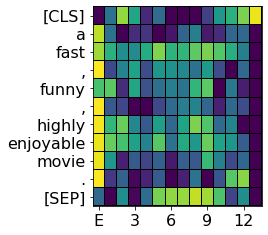

In [12]:
plot_sst_attributions(
    attributions_guan[:inputs_dict["mask"].sum(-1).item()].cpu(),
    tokens,
)

# Attention

In [13]:
model.net.bert.encoder.output_attentions = True
for l in model.net.bert.encoder.layer:
    l.attention.self.output_attentions = True
    
_, attention = model(**inputs_dict)

model.net.bert.encoder.output_attentions = False
for l in model.net.bert.encoder.layer:
    l.attention.self.output_attentions = False
    
attributions_att = torch.stack(
    [e.max(1).values.mean(-2) for e in attention], -1
)
attributions_att = torch.cat(
    (torch.full_like(attributions_att[...,0:1], float("nan")),
     attributions_att, 
     torch.full_like(attributions_att[...,0:1], float("nan"))), -1
)[0]

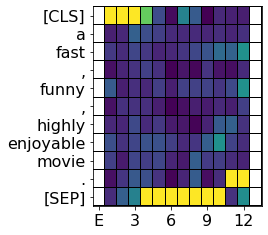

In [14]:
plot_sst_attributions(
    attributions_att[:inputs_dict["mask"].sum(-1).item()].cpu(),
    tokens,
)